# Project Final Report

Group Members: Mia , Selima, Daniel 


In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(httr)
library(readr)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## (1) Introduction

The project that we are working on surrounds the prediction of the usage of a video game research server. We are provided two datasets as a supplement to answer any predictive questions we came up with. This dataset is provided by the Pacific Laboratory for Artificial Intelligence, and they aim to understand in more detail the actions of players in the video game, Minecraft. In particular, our group is interested in understanding which player types contribute the most playing data.


>**Question:** How does the amount of hours a player spend on the server, and the number of sessions can accurately predict gender?

### (1) Data description of the 2 given data types:
The players.csv dataset contains observations of players of a Minecraft server:
- 196 observations (players)
- each player is described by 9 variables

|Column Name      |Data Type |Description                                                                 | 
|-----------------|:---------|:---------------------------------------------------------------------------|
|experience       |character |level of experience of the player (Pro, Veteran, Amateur, Regular, Beginner)|
|subscribe        |logical   |indicates if the player has subscribed                                      |
|hashedEmail      |character |anonymous player emails                                                     |
|played_hours     |double    |number of hours the player has spent on the server                          |
|name             |character |name of the player                                                          |
|gender           |character |gender of the player                                                        |
|age              |double    |age of the player                                                           |
|individualId     |logical   |possibly an identifier for specific groups                                  |
|organizationName |logical   |possibly intended for organizations linked to players                       |

The sessions.csv dataset contains observations of each player's playing session:
- 1535 observations (sessions)
- 5 variables
 
|Column Name         |Data Type |Description                                              | 
|--------------------|:---------|:--------------------------------------------------------|
|hashedEmail         |character |anonymous player emails                                  |
|start_time          |character |start date and time of a session                         |
|end_time            |character |end date and time of a session                           |
|original_start_time |double    |scheduled start time in UNIX timestamp format            |
|original_end_time   |double    |scheduled end time in UNIX timestamp format              |


## Methods and Results

### Loading and Wrangling

In [4]:
url1 <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
url2 <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"

players <- read_csv(url1) |>
    select(hashedEmail, played_hours, gender)

sessions <- read_csv(url2)  |> 
    select(hashedEmail) |>
    group_by(hashedEmail) |>
    summarize(session_count = n())

data <- left_join(sessions, players, by = "hashedEmail") |>
 filter(gender != "Agender", gender != "Other", gender != "Prefer not to say")


data

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,session_count,played_hours,gender
<chr>,<int>,<dbl>,<chr>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2,1.5,Male
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1,0.4,Male
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1,0.1,Male
⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310,56.1,Male
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1,0.1,Male
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1,1.1,Male


In [10]:
set.seed(1)

data <- data|>
  mutate(gender = as_factor(gender))

data_split <- initial_split(data, prop = 0.75, strata = gender)
data_train <- training(data_split)
data_test <- testing(data_split)

data_proportions <- data_train |>
                      group_by(gender) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(data_train))

data_proportions

gender,n,percent
<fct>,<int>,<dbl>
Male,62,71.264368
Female,18,20.689655
Non-binary,3,3.448276
Two-Spirited,4,4.597701


gender,n,percent
<fct>,<int>,<dbl>
Male,62,71.264368
Female,18,20.689655
Non-binary,3,3.448276
Two-Spirited,4,4.597701


→ A | warning: ✖ No observations were detected in `truth` for level: Two-Spirited.
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

→ B | warning: ✖ No observations were detected in `truth` for level: Non-binary.
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x2

There were issues with some computations   A: x1   B: x2



Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_line()`).”


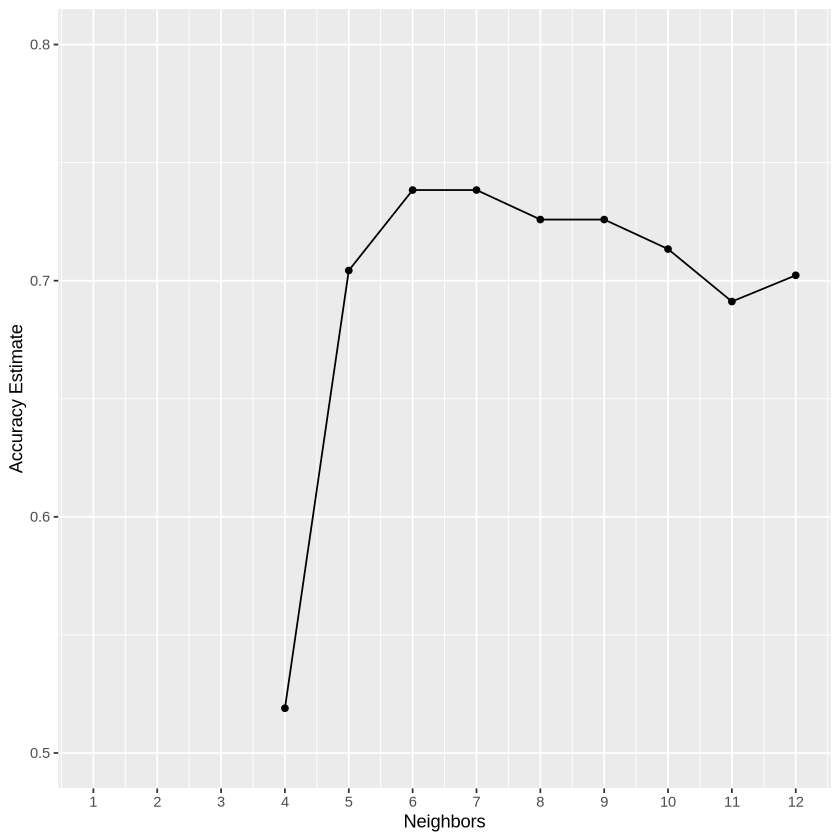

In [36]:
# data_recipe <- recipe(gender ~ session_count + played_hours, data = data_train) |>
#   step_scale(all_predictors()) |>
#   step_center(all_predictors())

# data_vfold <- vfold_cv(data_train, v = 10, strata = gender)

# # knn_fit <- workflow() |>
# #   add_recipe(data_recipe) |>
# #   add_model(knn_spec) |>
# #   fit_resamples(resamples = data_vfold)

# knn_spec <- nearest_neighbor(weight_func = "rectangular",
#                              neighbors = tune()) |>
#   set_engine("kknn") |>
#   set_mode("classification")

# k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

# knn_results <- workflow() |>
#   add_recipe(data_recipe) |>
#   add_model(knn_spec) |>
#   tune_grid(resamples = data_vfold, grid = k_vals) |>
#   collect_metrics()

# accuracies <- knn_results |>
#   filter(.metric == "accuracy")

# accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
#   geom_point() +
#   geom_line() +
#   labs(x = "Neighbors", y = "Accuracy Estimate") +
#   theme(text = element_text(size = 12))

# accuracy_vs_k
set.seed(1)

data <- data|>
  mutate(gender = as_factor(gender))

data_split <- initial_split(data, prop = 0.75, strata = gender)
data_train <- training(data_split)
data_test <- testing(data_split)

data_proportions <- data_train |>
                      group_by(gender) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(data_train))

data_proportions

data_recipe <- recipe(gender ~ session_count + played_hours, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

data_vfold <- vfold_cv(data_train, v = 5, strata = gender)

k_vals <- tibble(neighbors = seq(from = 1, to = 12, by = 1))

knn_results <- workflow() |>
       add_recipe(data_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = data_vfold, grid = k_vals) |>
       collect_metrics()

accuracies <- knn_results |> 
       filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 12, by = 1)) +  
       scale_y_continuous(limits = c(0.5, 0.8)) 
 
cross_val_plot

In [35]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 6

In [43]:
data_recipe <- recipe(gender ~ session_count + played_hours, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  fit(data = data_train)

data_test_predictions <- predict(knn_fit, data_test) |>
  bind_cols(data_test)

data_metrics <- data_test_predictions |>
  metrics(truth = gender, estimate = .pred_class) |>
  filter(.metric == "accuracy") 

data_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7


In [45]:
confusion <- data_test_predictions |>
             conf_mat(truth = gender, estimate = .pred_class)
confusion

              Truth
Prediction     Male Female Non-binary Two-Spirited
  Male           20      5          3            0
  Female          1      1          0            0
  Non-binary      0      0          0            0
  Two-Spirited    0      0          0            0

In [48]:
precision <- data_test_predictions|>
  precision(truth = gender, estimate = .pred_class, event_level = "first")

recall <- data_test_predictions|>
  recall(truth = gender, estimate = .pred_class, event_level = "first")

precision
recall

Warning message:
“While computing multiclass `precision()`, some levels had no predicted events
(i.e. `true_positive + false_positive = 0`).
Precision is undefined in this case, and those levels will be removed from the
averaged result.
Note that the following number of true events actually occurred for each
problematic event level:
'Non-binary': 3, 'Two-Spirited': 0”
Warning message:
“While computing multiclass `recall()`, some levels had no true events (i.e.
`true_positive + false_negative = 0`).
Recall is undefined in this case, and those levels will be removed from the
averaged result.
Note that the following number of predicted events actually occurred for each
problematic event level:
'Two-Spirited': 0”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,macro,0.6071429


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,macro,0.3730159


## 3) Discussion

> **summarize of findings and Interpretation of results**

The KNN model had moderate accuracy (70%) for predicting gender based on game time. This implies that a correlation exists between playtime, session count and gender, but they are not strong enough to explain or predict gender at a highly accurate approach.

Judging from the confusion matrix, the model best performs for the Male class, with 20 correct predictions. On the other hand, the female predictions have been relatively poor, with only 1 correct prediction and 5 being misclassified as male. The model completely failed to predict Non-binary by misclassifying all as male, and there were not any Two-Spirited classes in the testing set nor did the model predict it. 
The male class dominated most of the predictions, including true predictions and misclassified ones, which reflects the higher number of training examples for this class. This indicates that the dataset is imbalanced and is heavily weighed into males than other classes such as females, and even more for two-spirited and Non-binary. This observation weighs into the limitations of the dataset, where as the male data points are represented more heavily, the KNN model would be more biased towards the male class, which introduces less accuracy. 
The average precision for all classes was 0.61. However, it was important to note that the precision was undefined for “Two-Spirited” since there’s no predicted event available. This indicates that the model has a moderate ability to predict and avoid false positives, where it is correct 61% of the time averaging across the class labels. 
The average recall was 0.37, which means that the model cannot correctly identify most of the true events, in particular the underrepresented classes. 


The results somewhat aligned with our expectations. We know that it is likely to be difficult to see a valid relationship between the predictors and the class label due to the imbalance of labels (male more than other genders) and also the limited size of the dataset. This is also due to a preconceived knowledge that playtime, and session count may not be necessarily correlated with gender. Therefore, finding that there is somewhat of a relationship that exists with the prediction accuracy of 60% is similar to what we expected. However, we didn’t expect to see a complete failure to predict the minority categories (Non-binary, Two-Spirited). This can be explained by both due to limitations of the KNN algorithm and the size of the dataset itself. 

> **Impacts of findings and future explorations**

The results of this study could help the game developers of Minecraft to better cater its features or events, if they could see how playtime and session counts are associated with gender, to their respective demographic groups. It can also help address the imbalances in data collection and game design, especially since in this type of data collection, the predictive model would ignore the underrepresented genders and would only benefit the majority class, which is male. Therefore, this result, though doesn’t fully answer the research question, can address the importance of inclusivity of all genders. 

With this result, we can generate some questions to explore more on this variable: 

Can additional predictors that is not previously included in the datasets (e.g., in-game behaviours, communication styles) improve the model’s ability to predict gender? 

How can data collection methods ensure a better representation of minority classes? 
